In [3]:
# Data preparation
import pandas as pd
import numpy as np

# System
import os

# Plotting
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

# Normalization and cosine distance
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance

# Pyeer
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats

# Settings
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 8, 8

In [4]:
# Global variables
save_path = f"../evaluation/pyeer_lfwview2_unprotected_arcface_biometric_performance_nonorm/"
os.makedirs(save_path, exist_ok=True)

# Evaluation of biometric performance for PEMIU enhanced templates

Ingest dataframes containing path to LFW View 2 Target A and Target B for
- Original image
- PEMIU Shuffled embedding
- PEMIU Reconstructed embedding
- Block Size: See global variable above
- cos_sim between PEMIU Shuffled and Reconstructed embeddings

Add columns pointing to the unmodified embeddings. Reorder the columns for better readability.

In [5]:
df_genuine = pd.read_csv(f"../dataframes/lfw_view2_genuine_pemiu16.csv", sep=",")
df_impostor = pd.read_csv(f"../dataframes/lfw_view2_impostor_pemiu16.csv", sep=",")

# Add a column just containing the target name without extension
df_genuine['a_filename'] = df_genuine['a_img'].apply(lambda x: x.split('/')[-1].split('.')[0])
df_genuine['b_filename'] = df_genuine['b_img'].apply(lambda x: x.split('/')[-1].split('.')[0])
df_impostor['a_filename'] = df_impostor['a_img'].apply(lambda x: x.split('/')[-1].split('.')[0])
df_impostor['b_filename'] = df_impostor['b_img'].apply(lambda x: x.split('/')[-1].split('.')[0])

# Add columns with path pointing to unmodified templates
path_unmodified = "../data/features_cleaner/"
df_genuine['a_embedding_unmodified'] = df_genuine['a_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")
df_genuine['b_embedding_unmodified'] = df_genuine['b_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")
df_impostor['a_embedding_unmodified'] = df_impostor['a_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")
df_impostor['b_embedding_unmodified'] = df_impostor['b_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")

# Rename index column
df_genuine = df_genuine.rename(columns = {"Unnamed: 0": "index"})
df_impostor = df_impostor.rename(columns = {"Unnamed: 0": "index"})

# Reorder columns
df_genuine = df_genuine[['index',
                         
                         'a_filename',
                         'a_img',
                         'a_embedding_unmodified',
                         'a_embedding_pemiu',
                         'a_embedding_reconstructed',
                         
                         'b_filename',
                         'b_img',
                         'b_embedding_unmodified',
                         'b_embedding_pemiu',
                         
                         'cos_sim_a_pemiu_a_pemiu_reconstructed',
                        ]]

# Reorder columns
df_impostor = df_impostor[['index',
                         
                         'a_filename',
                         'a_img',
                         'a_embedding_unmodified',
                         'a_embedding_pemiu',
                         'a_embedding_reconstructed',
                         
                         'b_filename',
                         'b_img',
                         'b_embedding_unmodified',
                         'b_embedding_pemiu',
                         
                         'cos_sim_a_pemiu_a_pemiu_reconstructed',
                        ]]

df_genuine.drop(['a_embedding_pemiu', 'a_embedding_reconstructed', 'b_embedding_pemiu', 'cos_sim_a_pemiu_a_pemiu_reconstructed'], axis=1, inplace=True)
df_impostor.drop(['a_embedding_pemiu', 'a_embedding_reconstructed', 'b_embedding_pemiu', 'cos_sim_a_pemiu_a_pemiu_reconstructed'], axis=1, inplace=True)

## Calculate cos_sim

Calculate cosine similarity of
- target a / b embedding

In [6]:
# Cosine similarity according to Terhörst PEMIU implementation
def cos_sim(a, b):
    a, b = a.reshape(-1), b.reshape(-1)
    return np.dot(a,b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [7]:
# Load embeddings
genuine_a = df_genuine['a_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()
genuine_b = df_genuine['b_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()
impostor_a = df_impostor['a_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()
impostor_b = df_impostor['b_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()

# Calculate cosine similarity
df_genuine['cos_sim_a_b'] = [(cos_sim(x, y)) for x, y in zip(genuine_a, genuine_b)]
df_impostor['cos_sim_a_b'] = [(cos_sim(x, y)) for x, y in zip(impostor_a, impostor_b)]

## Plot

Visualize the distribution of genuine and impostor pairs for both unprotected and PEMIU enhanced templates on a normalized scale.

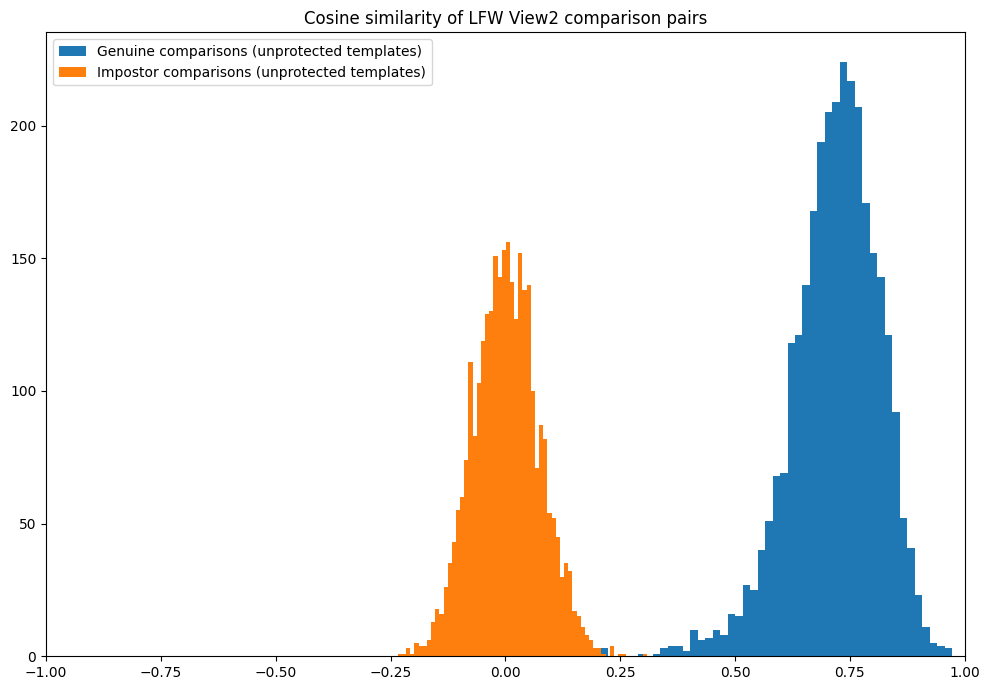

In [9]:
fig, ax = plt.subplots(1, 1,
                        figsize = (10, 7),
                        tight_layout = True)

# Comparison: Genuine and imnpostor
ax.hist(df_genuine['cos_sim_a_b'], bins = 60, label="Genuine comparisons (unprotected templates)")
ax.hist(df_impostor['cos_sim_a_b'], bins = 60, label="Impostor comparisons (unprotected templates)")

ax.legend()
ax.set_title("Cosine similarity of LFW View2 comparison pairs")
plt.xlim([-1, 1])
    
# Show plot
plt.show()

## Pyeer report

In [10]:
stats_unprotected = get_eer_stats(
    df_genuine['cos_sim_a_b'],
    df_impostor['cos_sim_a_b'],
    ds_scores=False)

In [11]:
# Export
generate_eer_report([stats_unprotected],
                    ['Unprotected'],
                    save_path + "eer_report_alt.csv")

export_error_rates(stats_unprotected.fmr, stats_unprotected.fnmr, save_path + 'A_DET.csv')

plot_eer_stats([stats_unprotected], ['unprotected'], save_path=save_path)

In [12]:
df_pyeer = pd.read_csv(f"{save_path}eer_report_alt.csv", 
                       sep=",", skiprows=[0])
df_pyeer.drop(df_pyeer.index[1:], inplace=True)
df_pyeer.T

,0
Experiment ID,Unprotected
GMean,0.716181
GSTD,0.102242
IMean,0.002586
ISTD,0.071711
Sensitivity index (d'),8.080924
AUC,0.99924
J-Index,0.995667
J-Index_TH,0.289894
MCC,0.995676


In [13]:
labels = ["TMR Zero\t\t", "TMR 1000 (10^3)\t\t", "TMR  100 (10^2)\t\t", "TMR   10\t\t"]

for i, title in enumerate(['Bona Fide Comparison Unprotected']):
    print(f"\n{title}")
    for index, row in enumerate(df_pyeer[['ZeroFMR', 'FMR1000', 'FMR100', 'FMR10']]):
        print(f"{labels[index]}: {round(((1 - (df_pyeer[row].values[i])) * 100), 2)} %")


Bona Fide Comparison Unprotected
TMR Zero		: 99.57 %
TMR 1000 (10^3)		: 99.6 %
TMR  100 (10^2)		: 99.73 %
TMR   10		: 99.83 %
